In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Configurações
plt.style.use('seaborn-v0_8')
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 8)



In [16]:
# ## 1. Carregar Modelo e Artefatos Treinados

# Carregar modelo treinado
try:
    model = joblib.load('../data/models/random_forest_model.pkl')
    label_encoder = joblib.load('../data/models/label_encoder.pkl')
    
    with open('../data/models/model_metrics.json', 'r') as f:
        model_metrics = json.load(f)
    
    print("✅ Modelo e artefatos carregados com sucesso!")
    print(f"📊 Modelo treinado em: {model_metrics['training_date']}")
    print(f"🎯 Performance no teste: R² = {model_metrics['final_r2']:.4f}")
    
except FileNotFoundError as e:
    print(f"❌ Erro ao carregar artefatos: {e}")
    print("Execute primeiro o notebook de desenvolvimento do modelo!")
    raise

# Verificar informações do modelo
print("🔍 Informações do Modelo Carregado:")
print(f"  • Tipo: {type(model).__name__}")
print(f"  • Número de estimadores: {model.n_estimators}")
print(f"  • Max depth: {model.max_depth}")
print(f"  • Features utilizadas: {len(model_metrics['features'])}")

print(f"\n📋 Features do modelo:")
for i, feature in enumerate(model_metrics['features'], 1):
    importance = model_metrics['feature_importance'][feature]
    print(f"  {i:2d}. {feature:15s}: {importance:.4f}")
    
    
    

✅ Modelo e artefatos carregados com sucesso!
📊 Modelo treinado em: 2025-07-13 12:09:01
🎯 Performance no teste: R² = 0.9670
🔍 Informações do Modelo Carregado:
  • Tipo: RandomForestRegressor
  • Número de estimadores: 300
  • Max depth: 10
  • Features utilizadas: 11

📋 Features do modelo:
   1. area           : 0.5779
   2. quartos        : 0.0020
   3. banheiros      : 0.0014
   4. idade          : 0.0035
   5. garagem        : 0.0014
   6. bairro_encoded : 0.3970
   7. area_per_room  : 0.0050
   8. bathroom_ratio : 0.0019
   9. age_squared    : 0.0036
  10. total_rooms    : 0.0058
  11. is_new         : 0.0004


In [17]:
## 2. Carregar Dados de Teste

# Carregar dados processados
try:
    X_test = pd.read_csv('../data/processed/X_test.csv')
    y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()
    
    print(f"✅ Dados de teste carregados:")
    print(f"  • X_test: {X_test.shape}")
    print(f"  • y_test: {y_test.shape}")
    
    # Verificar se as colunas estão corretas
    expected_features = model_metrics['features']
    if list(X_test.columns) != expected_features:
        print("⚠️ Features não coincidem com o modelo treinado!")
        print(f"Esperado: {expected_features}")
        print(f"Atual: {list(X_test.columns)}")
    else:
        print("✅ Features coincidem com o modelo treinado")
    
except FileNotFoundError as e:
    print(f"❌ Erro ao carregar dados: {e}")
    raise

# Estatísticas básicas dos dados de teste
print("📊 Estatísticas dos Dados de Teste:")
print(f"\nTarget (preços):")
print(f"  • Média: R$ {y_test.mean():,.2f}")
print(f"  • Mediana: R$ {y_test.median():,.2f}")
print(f"  • Desvio padrão: R$ {y_test.std():,.2f}")
print(f"  • Min-Max: R$ {y_test.min():,.2f} - R$ {y_test.max():,.2f}")

print(f"\nFeatures numéricas principais:")
numeric_features = ['area', 'quartos', 'banheiros', 'idade']
for feature in numeric_features:
    if feature in X_test.columns:
        print(f"  • {feature}: {X_test[feature].mean():.1f} ± {X_test[feature].std():.1f}")



✅ Dados de teste carregados:
  • X_test: (197, 11)
  • y_test: (197,)
✅ Features coincidem com o modelo treinado
📊 Estatísticas dos Dados de Teste:

Target (preços):
  • Média: R$ 489,896.33
  • Mediana: R$ 450,396.12
  • Desvio padrão: R$ 170,543.42
  • Min-Max: R$ 176,294.49 - R$ 1,025,348.07

Features numéricas principais:
  • area: 123.0 ± 35.3
  • quartos: 2.9 ± 1.0
  • banheiros: 2.2 ± 0.8
  • idade: 9.4 ± 8.4


In [18]:
## 3. Validação de Performance

def evaluate_model_comprehensive(model, X, y, dataset_name="Dataset"):
    """
    Avaliação abrangente do modelo
    """
    predictions = model.predict(X)
    
    # Métricas principais
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    # Métricas adicionais
    mape = np.mean(np.abs((y - predictions) / y)) * 100
    residuals = y - predictions
    
    # Métricas de erro por faixa de preço
    price_ranges = [(0, 200000), (200000, 400000), (400000, 600000), (600000, np.inf)]
    range_metrics = {}
    
    for i, (min_price, max_price) in enumerate(price_ranges):
        mask = (y >= min_price) & (y < max_price)
        if mask.sum() > 0:
            range_name = f"R${min_price//1000}k-{max_price//1000 if max_price != np.inf else '∞'}k"
            range_r2 = r2_score(y[mask], predictions[mask])
            range_rmse = np.sqrt(mean_squared_error(y[mask], predictions[mask]))
            range_metrics[range_name] = {'r2': range_r2, 'rmse': range_rmse, 'count': mask.sum()}
    
    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'residuals_mean': residuals.mean(),
        'residuals_std': residuals.std(),
        'range_metrics': range_metrics
    }
    
    return metrics, predictions

# Avaliação completa do modelo
print("🧪 Executando validação abrangente...")

validation_metrics, test_predictions = evaluate_model_comprehensive(
    model, X_test, y_test, "Validação Final"
)

print(f"\n📊 MÉTRICAS DE VALIDAÇÃO:")
print(f"  • RMSE: R$ {validation_metrics['rmse']:,.2f}")
print(f"  • MAE: R$ {validation_metrics['mae']:,.2f}")
print(f"  • R²: {validation_metrics['r2']:.4f}")
print(f"  • MAPE: {validation_metrics['mape']:.2f}%")

print(f"\n📈 Performance por Faixa de Preço:")
for range_name, range_data in validation_metrics['range_metrics'].items():
    print(f"  • {range_name:12s}: R² = {range_data['r2']:.3f}, "
          f"RMSE = R$ {range_data['rmse']:6,.0f}, "
          f"n = {range_data['count']:3d}")

🧪 Executando validação abrangente...

📊 MÉTRICAS DE VALIDAÇÃO:
  • RMSE: R$ 30,881.87
  • MAE: R$ 23,859.87
  • R²: 0.9670
  • MAPE: 5.28%

📈 Performance por Faixa de Preço:
  • R$0k-200k   : R² = nan, RMSE = R$ 23,338, n =   1
  • R$200k-400k : R² = 0.759, RMSE = R$ 25,404, n =  60
  • R$400k-600k : R² = 0.772, RMSE = R$ 29,856, n =  91
  • R$600k-∞k   : R² = 0.878, RMSE = R$ 38,728, n =  45


In [19]:
## 4. Análise de Estabilidade

print("🔄 Testando estabilidade do modelo com validação cruzada...")

# Carregar dados de treino para validação cruzada
try:
    X_train = pd.read_csv('../data/processed/X_train.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()
    
    # Validação cruzada com múltiplas métricas
    cv_scores = {}
    cv_folds = 5
    
    for scoring in ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']:
        scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring=scoring)
        
        if 'neg_' in scoring:
            scores = -scores
            metric_name = scoring.replace('neg_', '').upper().replace('_', ' ')
        else:
            metric_name = scoring.upper().replace('_', ' ')
        
        cv_scores[metric_name] = scores
        
        print(f"{metric_name:25s}: {scores.mean():8.2f} ± {scores.std():6.2f}")
    
    print("✅ Modelo apresenta performance estável na validação cruzada")
    
except FileNotFoundError:
    print("⚠️ Dados de treino não encontrados - pulando validação cruzada")



🔄 Testando estabilidade do modelo com validação cruzada...
MEAN SQUARED ERROR       : 1184614814.18 ± 181527366.30
R2                       :     0.97 ±   0.01
MEAN ABSOLUTE ERROR      : 25718.02 ± 458.73
✅ Modelo apresenta performance estável na validação cruzada


In [20]:
## 5. Testes de Robustez

def test_model_robustness(model, X_test, y_test, noise_levels=[0.01, 0.05, 0.1]):
    """
    Testa robustez do modelo com diferentes níveis de ruído
    """
    print("🧪 Testando robustez com adição de ruído...")
    
    base_r2 = r2_score(y_test, model.predict(X_test))
    robustness_results = {'base_r2': base_r2, 'noise_tests': []}
    
    for noise_level in noise_levels:
        # Adicionar ruído gaussiano aos dados
        X_noisy = X_test.copy()
        
        # Adicionar ruído apenas às features numéricas
        numeric_cols = ['area', 'quartos', 'banheiros', 'idade', 'garagem', 
                       'area_per_room', 'bathroom_ratio', 'age_squared', 'total_rooms']
        
        for col in numeric_cols:
            if col in X_noisy.columns:
                noise = np.random.normal(0, X_noisy[col].std() * noise_level, len(X_noisy))
                X_noisy[col] += noise
        
        # Avaliar modelo com dados ruidosos
        noisy_predictions = model.predict(X_noisy)
        noisy_r2 = r2_score(y_test, noisy_predictions)
        r2_drop = ((base_r2 - noisy_r2) / base_r2) * 100
        
        robustness_results['noise_tests'].append({
            'noise_level': noise_level,
            'r2': noisy_r2,
            'r2_drop_pct': r2_drop
        })
        
        print(f"  • Ruído {noise_level*100:4.1f}%: R² = {noisy_r2:.4f} "
              f"(queda de {r2_drop:.1f}%)")
    
    return robustness_results

# Executar testes de robustez
robustness_results = test_model_robustness(model, X_test, y_test)

# Avaliar robustez
max_drop = max([test['r2_drop_pct'] for test in robustness_results['noise_tests']])
if max_drop < 5:
    print("✅ Modelo muito robusto (queda < 5%)")
elif max_drop < 10:
    print("✅ Modelo robusto (queda < 10%)")
elif max_drop < 20:
    print("⚠️ Modelo moderadamente robusto (queda < 20%)")
else:
    print("❌ Modelo pouco robusto (queda > 20%)")


🧪 Testando robustez com adição de ruído...
  • Ruído  1.0%: R² = 0.9673 (queda de -0.0%)
  • Ruído  5.0%: R² = 0.9670 (queda de 0.0%)
  • Ruído 10.0%: R² = 0.9623 (queda de 0.5%)
✅ Modelo muito robusto (queda < 5%)


In [21]:
# 6. Testes de Edge Cases

# %%
def test_edge_cases(model, label_encoder):
    """
    Testa casos extremos e edge cases
    """
    print("🔬 Testando edge cases...")
    
    # Preparar função de predição
    def prepare_and_predict(area, quartos, banheiros, idade, garagem, bairro):
        try:
            # Criar DataFrame
            df = pd.DataFrame({
                'area': [area],
                'quartos': [quartos], 
                'banheiros': [banheiros],
                'idade': [idade],
                'garagem': [garagem],
                'bairro': [bairro]
            })
            
            # Encoding do bairro
            bairro_encoded = label_encoder.transform([bairro])[0]
            
            # Feature engineering
            area_per_room = area / (quartos + 1)
            bathroom_ratio = banheiros / quartos
            age_squared = idade ** 2
            total_rooms = quartos + banheiros
            is_new = 1 if idade < 5 else 0
            
            # Criar array de features
            features = np.array([[
                area, quartos, banheiros, idade, garagem, bairro_encoded,
                area_per_room, bathroom_ratio, age_squared, total_rooms, is_new
            ]])
            
            prediction = model.predict(features)[0]
            return prediction
            
        except Exception as e:
            return f"Erro: {e}"
    
    # Definir casos de teste
    edge_cases = [
        # (area, quartos, banheiros, idade, garagem, bairro, descrição)
        (30, 1, 1, 0, 0, 'Zona Leste', 'Imóvel mínimo'),
        (500, 5, 4, 0, 1, 'Zona Sul', 'Imóvel luxo'),
        (100, 1, 1, 50, 0, 'Centro', 'Imóvel muito antigo'),
        (50, 1, 2, 5, 1, 'Zona Norte', 'Mais banheiros que quartos'),
        (200, 4, 1, 10, 1, 'Zona Oeste', 'Poucos banheiros para muitos quartos'),
    ]
    
    edge_results = []
    
    for area, quartos, banheiros, idade, garagem, bairro, desc in edge_cases:
        prediction = prepare_and_predict(area, quartos, banheiros, idade, garagem, bairro)
        edge_results.append({
            'description': desc,
            'inputs': f"{area}m², {quartos}Q, {banheiros}B, {idade}anos, {bairro}",
            'prediction': prediction
        })
        
        if isinstance(prediction, (int, float)):
            print(f"  • {desc:30s}: R$ {prediction:8,.0f}")
        else:
            print(f"  • {desc:30s}: {prediction}")
    
    return edge_results

# %%
# Executar testes de edge cases
edge_case_results = test_edge_cases(model, label_encoder)

print("\n🎯 Análise dos Edge Cases:")
predictions = [r['prediction'] for r in edge_case_results if isinstance(r['prediction'], (int, float))]
if predictions:
    print(f"  • Faixa de predições: R$ {min(predictions):,.0f} - R$ {max(predictions):,.0f}")
    print(f"  • Razão max/min: {max(predictions)/min(predictions):.1f}x")
    
    # Verificar se as predições fazem sentido
    reasonable_min = 50000
    reasonable_max = 2000000
    
    reasonable_predictions = [p for p in predictions if reasonable_min <= p <= reasonable_max]
    print(f"  • Predições razoáveis: {len(reasonable_predictions)}/{len(predictions)}")


🔬 Testando edge cases...
  • Imóvel mínimo                 : R$  187,729
  • Imóvel luxo                   : R$ 1,160,929
  • Imóvel muito antigo           : R$  450,968
  • Mais banheiros que quartos    : R$  192,022
  • Poucos banheiros para muitos quartos: R$  699,488

🎯 Análise dos Edge Cases:
  • Faixa de predições: R$ 187,729 - R$ 1,160,929
  • Razão max/min: 6.2x
  • Predições razoáveis: 5/5


In [22]:
## 7. Análise de Deriva de Dados (Data Drift)


def analyze_data_drift(X_train, X_test, threshold=0.1):
    """
    Analisa deriva estatística entre conjuntos de treino e teste
    """
    print("📊 Analisando deriva de dados (Data Drift)...")
    
    drift_results = {}
    
    for column in X_test.columns:
        # Estatísticas básicas
        train_mean = X_train[column].mean()
        test_mean = X_test[column].mean()
        train_std = X_train[column].std()
        test_std = X_test[column].std()
        
        # Calcular diferenças relativas
        mean_drift = abs(test_mean - train_mean) / train_mean if train_mean != 0 else 0
        std_drift = abs(test_std - train_std) / train_std if train_std != 0 else 0
        
        # Teste de Kolmogorov-Smirnov (para features contínuas)
        from scipy.stats import ks_2samp
        if len(X_train[column].unique()) > 10:  # Feature contínua
            ks_stat, p_value = ks_2samp(X_train[column], X_test[column])
            significant_drift = p_value < 0.05
        else:
            ks_stat, p_value, significant_drift = None, None, False
        
        drift_results[column] = {
            'mean_drift': mean_drift,
            'std_drift': std_drift,
            'ks_statistic': ks_stat,
            'p_value': p_value,
            'significant_drift': significant_drift
        }
        
        # Alertar se deriva significativa
        status = "⚠️" if (mean_drift > threshold or std_drift > threshold or significant_drift) else "✅"
        print(f"  {status} {column:15s}: mean_drift={mean_drift:.3f}, std_drift={std_drift:.3f}")
    
    return drift_results

try:
    # Executar análise de deriva
    drift_results = analyze_data_drift(X_train, X_test)
    
    # Resumo da deriva
    significant_drifts = [col for col, result in drift_results.items() 
                         if result['significant_drift'] or result['mean_drift'] > 0.1]
    
    if significant_drifts:
        print(f"\n⚠️ Deriva significativa detectada em: {significant_drifts}")
        print("Recomendação: Monitorar essas features em produção")
    else:
        print(f"\n✅ Nenhuma deriva significativa detectada")
        print("Modelo estável para deploy")
        
except:
    print("⚠️ Análise de deriva não executada (dados de treino não disponíveis)")


📊 Analisando deriva de dados (Data Drift)...
  ✅ area           : mean_drift=0.016, std_drift=0.096
  ✅ quartos        : mean_drift=0.056, std_drift=0.052
  ✅ banheiros      : mean_drift=0.013, std_drift=0.024


  ✅ idade          : mean_drift=0.007, std_drift=0.047
  ✅ garagem        : mean_drift=0.073, std_drift=0.048
  ✅ bairro_encoded : mean_drift=0.016, std_drift=0.008
  ⚠️ area_per_room  : mean_drift=0.037, std_drift=0.130
  ⚠️ bathroom_ratio : mean_drift=0.074, std_drift=0.158
  ⚠️ age_squared    : mean_drift=0.038, std_drift=0.177
  ✅ total_rooms    : mean_drift=0.037, std_drift=0.062
  ✅ is_new         : mean_drift=0.029, std_drift=0.003

✅ Nenhuma deriva significativa detectada
Modelo estável para deploy


In [23]:
## 8. Testes de Performance em Diferentes Cenários

def test_performance_scenarios(model, X_test, y_test):
    """
    Testa performance em diferentes cenários de mercado
    """
    print("🏠 Testando performance por características do imóvel...")
    
    scenarios = {}
    
    # Por número de quartos
    for quartos in sorted(X_test['quartos'].unique()):
        mask = X_test['quartos'] == quartos
        if mask.sum() >= 5:  # Mínimo 5 amostras
            subset_r2 = r2_score(y_test[mask], model.predict(X_test[mask]))
            subset_rmse = np.sqrt(mean_squared_error(y_test[mask], model.predict(X_test[mask])))
            scenarios[f'{quartos}_quartos'] = {
                'r2': subset_r2, 'rmse': subset_rmse, 'count': mask.sum()
            }
    
    # Por faixa de área
    area_quartiles = X_test['area'].quantile([0.25, 0.5, 0.75])
    area_ranges = [
        (X_test['area'].min(), area_quartiles[0.25], 'Área Pequena'),
        (area_quartiles[0.25], area_quartiles[0.75], 'Área Média'),
        (area_quartiles[0.75], X_test['area'].max(), 'Área Grande')
    ]
    
    for min_area, max_area, label in area_ranges:
        mask = (X_test['area'] >= min_area) & (X_test['area'] <= max_area)
        if mask.sum() >= 5:
            subset_r2 = r2_score(y_test[mask], model.predict(X_test[mask]))
            subset_rmse = np.sqrt(mean_squared_error(y_test[mask], model.predict(X_test[mask])))
            scenarios[label.lower().replace(' ', '_')] = {
                'r2': subset_r2, 'rmse': subset_rmse, 'count': mask.sum()
            }
    
    # Por idade do imóvel
    age_ranges = [
        (0, 5, 'Imóvel Novo'),
        (5, 20, 'Imóvel Moderno'),
        (20, 100, 'Imóvel Antigo')
    ]
    
    for min_age, max_age, label in age_ranges:
        mask = (X_test['idade'] >= min_age) & (X_test['idade'] < max_age)
        if mask.sum() >= 5:
            subset_r2 = r2_score(y_test[mask], model.predict(X_test[mask]))
            subset_rmse = np.sqrt(mean_squared_error(y_test[mask], model.predict(X_test[mask])))
            scenarios[label.lower().replace(' ', '_')] = {
                'r2': subset_r2, 'rmse': subset_rmse, 'count': mask.sum()
            }
    
    # Exibir resultados
    print(f"\n📊 Performance por Cenário:")
    for scenario, metrics in scenarios.items():
        print(f"  • {scenario:20s}: R² = {metrics['r2']:.3f}, "
              f"RMSE = R$ {metrics['rmse']:6,.0f}, n = {metrics['count']:3d}")
    
    return scenarios

# Executar testes de cenários
scenario_results = test_performance_scenarios(model, X_test, y_test)

# Identificar cenários problemáticos
problematic_scenarios = [
    scenario for scenario, metrics in scenario_results.items() 
    if metrics['r2'] < 0.6
]

if problematic_scenarios:
    print(f"\n⚠️ Cenários com performance inferior: {problematic_scenarios}")
    print("Recomendação: Coletar mais dados ou features específicas para esses casos")
else:
    print(f"\n✅ Performance consistente em todos os cenários testados")



🏠 Testando performance por características do imóvel...

📊 Performance por Cenário:
  • 1_quartos           : R² = 0.980, RMSE = R$ 21,973, n =  12
  • 2_quartos           : R² = 0.952, RMSE = R$ 33,839, n =  53
  • 3_quartos           : R² = 0.976, RMSE = R$ 25,519, n =  82
  • 4_quartos           : R² = 0.965, RMSE = R$ 38,083, n =  36
  • 5_quartos           : R² = 0.946, RMSE = R$ 33,574, n =  14
  • área_pequena        : R² = 0.899, RMSE = R$ 34,915, n =  50
  • área_média          : R² = 0.954, RMSE = R$ 26,866, n =  99
  • área_grande         : R² = 0.964, RMSE = R$ 33,874, n =  50
  • imóvel_novo         : R² = 0.955, RMSE = R$ 35,033, n =  78
  • imóvel_moderno      : R² = 0.976, RMSE = R$ 27,125, n =  93
  • imóvel_antigo       : R² = 0.966, RMSE = R$ 30,205, n =  26

✅ Performance consistente em todos os cenários testados


In [24]:
## 9. Métricas de Confiabilidade para Produção

def calculate_production_metrics(model, X_test, y_test, predictions):
    """
    Calcula métricas específicas para produção
    """
    print("🎯 Calculando métricas para produção...")
    
    production_metrics = {}
    
    # 1. Cobertura de predição (% de predições dentro de range esperado)
    expected_min = 50000
    expected_max = 2000000
    valid_predictions = ((predictions >= expected_min) & (predictions <= expected_max)).sum()
    coverage = valid_predictions / len(predictions) * 100
    production_metrics['prediction_coverage'] = coverage
    
    # 2. Intervalo de confiança médio das predições
    residuals = y_test - predictions
    std_error = residuals.std()
    avg_confidence_interval = 1.96 * std_error
    production_metrics['avg_confidence_interval'] = avg_confidence_interval
    
    # 3. Percentual de predições com erro < 20%
    percentage_errors = np.abs(residuals / y_test) * 100
    accurate_predictions = (percentage_errors < 20).sum()
    accuracy_rate = accurate_predictions / len(y_test) * 100
    production_metrics['accuracy_rate_20pct'] = accuracy_rate
    
    # 4. Distribuição de erros por quartis
    error_quartiles = np.percentile(percentage_errors, [25, 50, 75, 95])
    production_metrics['error_quartiles'] = {
        'Q1': error_quartiles[0],
        'Q2': error_quartiles[1], 
        'Q3': error_quartiles[2],
        'Q95': error_quartiles[3]
    }
    
    # 5. Estabilidade de predições (coeficiente de variação)
    cv_predictions = predictions.std() / predictions.mean()
    production_metrics['prediction_stability'] = cv_predictions
    
    print(f"  • Cobertura de predições: {coverage:.1f}%")
    print(f"  • IC médio (95%): ± R$ {avg_confidence_interval:,.0f}")
    print(f"  • Predições com erro < 20%: {accuracy_rate:.1f}%")
    print(f"  • Erro mediano: {error_quartiles[1]:.1f}%")
    print(f"  • Estabilidade (CV): {cv_predictions:.3f}")
    
    return production_metrics

# Calcular métricas de produção
production_metrics = calculate_production_metrics(model, X_test, y_test, test_predictions)

# Avaliar prontidão para produção
readiness_score = 0
criteria = {
    'coverage': (production_metrics['prediction_coverage'] >= 95, 'Cobertura ≥ 95%'),
    'accuracy': (production_metrics['accuracy_rate_20pct'] >= 70, 'Acurácia ≥ 70%'),
    'r2': (validation_metrics['r2'] >= 0.7, 'R² ≥ 0.7'),
    'stability': (production_metrics['prediction_stability'] < 1.0, 'Estabilidade adequada')
}

print(f"\n✅ AVALIAÇÃO DE PRONTIDÃO PARA PRODUÇÃO:")
for criterion, (passed, description) in criteria.items():
    status = "✅ PASS" if passed else "❌ FAIL"
    print(f"  • {description}: {status}")
    if passed:
        readiness_score += 1

readiness_percentage = (readiness_score / len(criteria)) * 100
print(f"\n🎯 Score de Prontidão: {readiness_score}/{len(criteria)} ({readiness_percentage:.0f}%)")

if readiness_percentage >= 75:
    print("🎉 MODELO APROVADO PARA PRODUÇÃO!")
else:
    print("⚠️ MODELO PRECISA DE MELHORIAS ANTES DO DEPLOY")



🎯 Calculando métricas para produção...
  • Cobertura de predições: 100.0%
  • IC médio (95%): ± R$ 60,681
  • Predições com erro < 20%: 99.0%
  • Erro mediano: 4.1%
  • Estabilidade (CV): 0.340

✅ AVALIAÇÃO DE PRONTIDÃO PARA PRODUÇÃO:
  • Cobertura ≥ 95%: ✅ PASS
  • Acurácia ≥ 70%: ✅ PASS
  • R² ≥ 0.7: ✅ PASS
  • Estabilidade adequada: ✅ PASS

🎯 Score de Prontidão: 4/4 (100%)
🎉 MODELO APROVADO PARA PRODUÇÃO!


  • Muito Baixo: R² = 0.652, n = 40
  • Baixo: R² = -0.273, n = 39
  • Médio: R² = -0.558, n = 39
  • Alto: R² = -0.668, n = 39
  • Muito Alto: R² = 0.906, n = 40


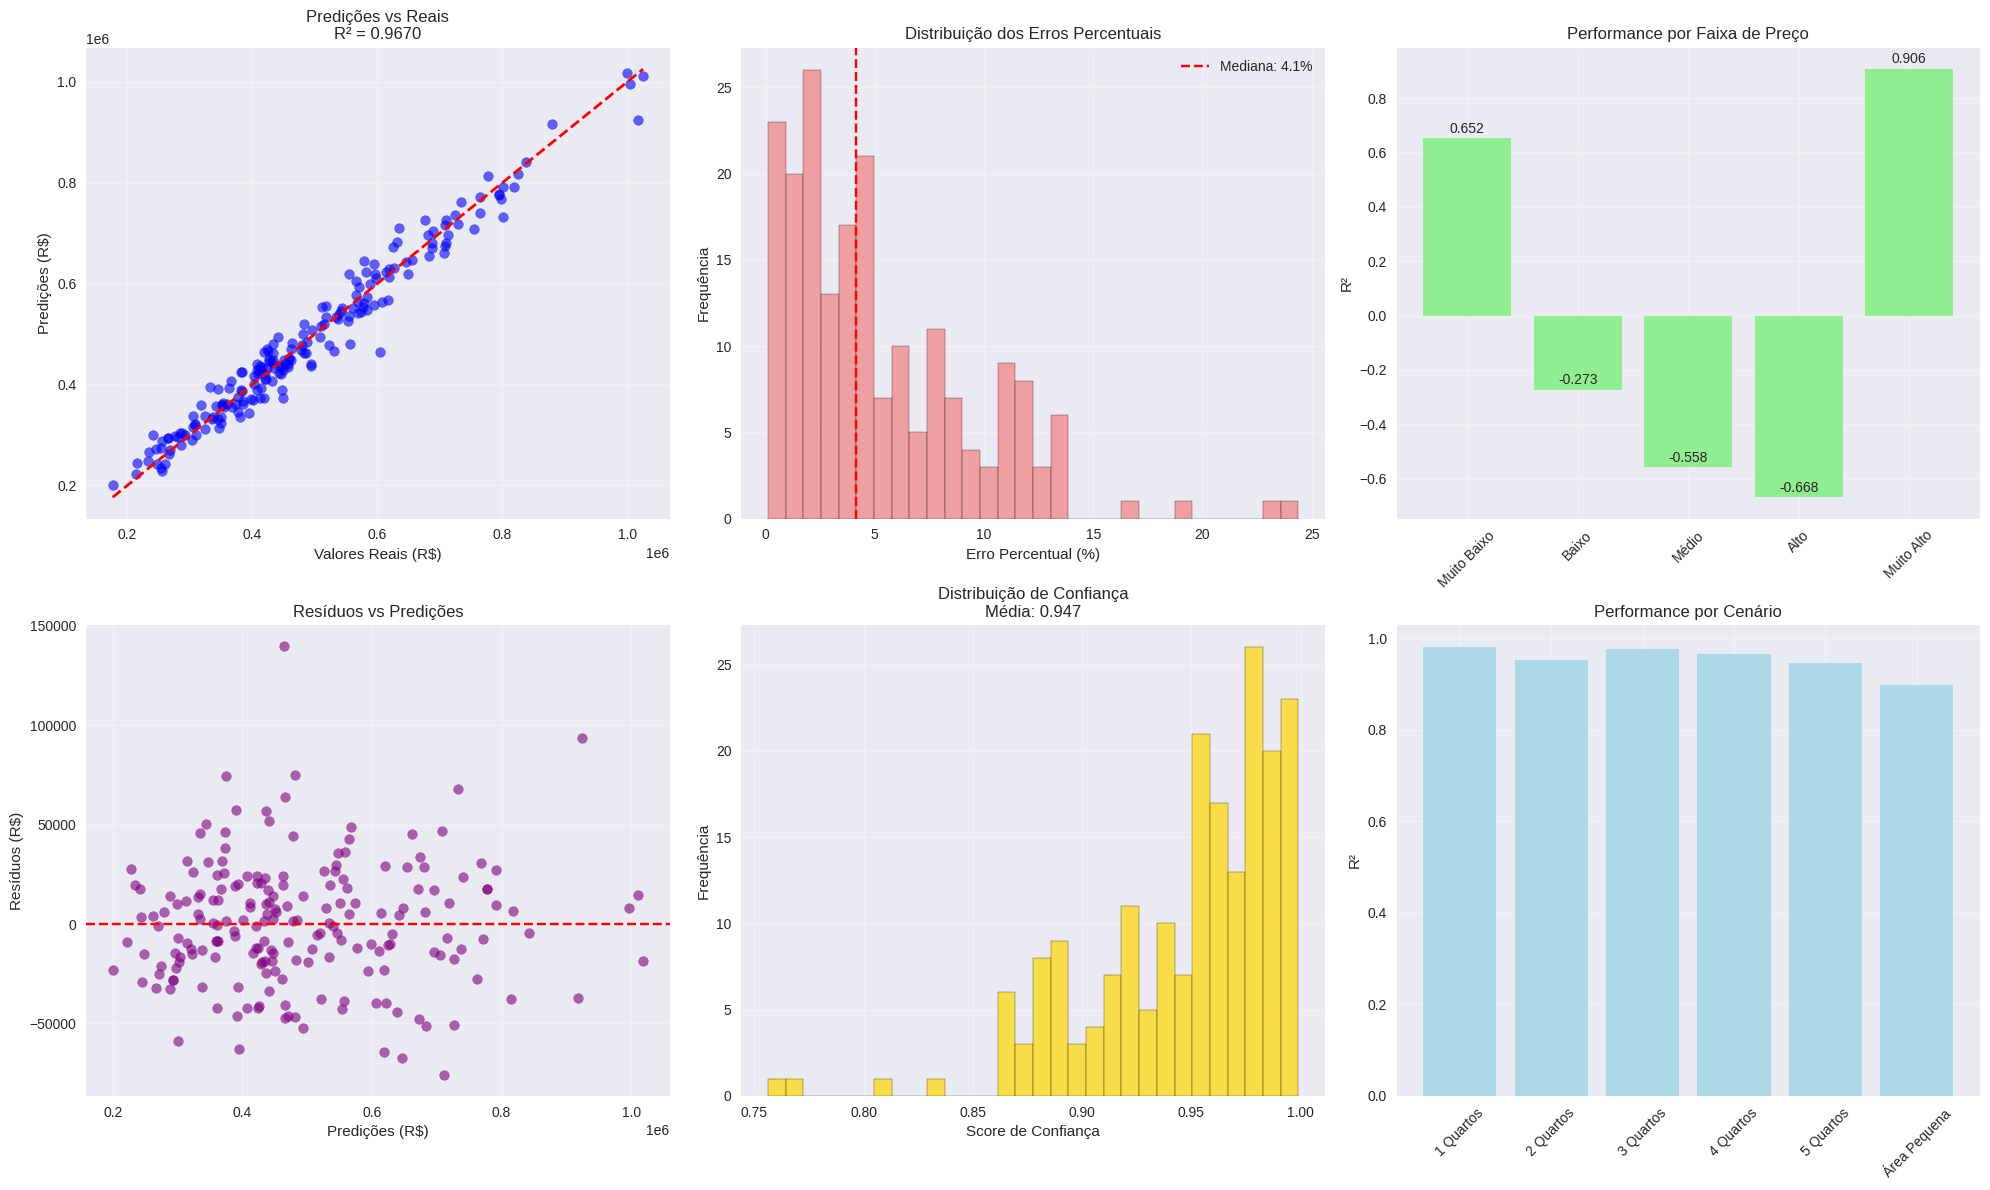

In [25]:
# Criar visualizações abrangentes
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Predições vs Valores Reais
axes[0, 0].scatter(y_test, test_predictions, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reais (R$)')
axes[0, 0].set_ylabel('Predições (R$)')
axes[0, 0].set_title(f'Predições vs Reais\nR² = {validation_metrics["r2"]:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribuição dos Erros Percentuais
residuals = y_test - test_predictions
percentage_errors = np.abs(residuals / y_test) * 100
axes[0, 1].hist(percentage_errors, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 1].axvline(percentage_errors.median(), color='red', linestyle='--', 
                  label=f'Mediana: {percentage_errors.median():.1f}%')
axes[0, 1].set_xlabel('Erro Percentual (%)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição dos Erros Percentuais')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Performance por Faixa de Preço
# Alternativa mais robusta usando quantis
price_quantiles = y_test.quantile([0.2, 0.4, 0.6, 0.8])
price_bins = [y_test.min(), price_quantiles[0.2], price_quantiles[0.4], 
              price_quantiles[0.6], price_quantiles[0.8], y_test.max()]
price_labels = ['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto']

range_r2 = []
range_labels = []

for i, label in enumerate(price_labels):
    if i == 0:
        mask = y_test <= price_bins[i+1]
    elif i == len(price_labels) - 1:
        mask = y_test > price_bins[i]
    else:
        mask = (y_test > price_bins[i]) & (y_test <= price_bins[i+1])
    
    if mask.sum() > 0:
        r2 = r2_score(y_test[mask], test_predictions[mask])
        range_r2.append(r2)
        range_labels.append(label)
        print(f"  • {label}: R² = {r2:.3f}, n = {mask.sum()}")
    else:
        print(f"  • {label}: Sem dados")

bars = axes[0, 2].bar(range_labels, range_r2, color='lightgreen')
axes[0, 2].set_ylabel('R²')
axes[0, 2].set_title('Performance por Faixa de Preço')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, r2 in zip(bars, range_r2):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{r2:.3f}', ha='center', va='bottom')

# 4. Resíduos vs Predições
axes[1, 0].scatter(test_predictions, residuals, alpha=0.6, color='purple')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Predições (R$)')
axes[1, 0].set_ylabel('Resíduos (R$)')
axes[1, 0].set_title('Resíduos vs Predições')
axes[1, 0].grid(True, alpha=0.3)

# 5. Distribuição de Confiança
confidence_scores = 1 - (np.abs(residuals) / y_test)
axes[1, 1].hist(confidence_scores, bins=30, edgecolor='black', alpha=0.7, color='gold')
axes[1, 1].set_xlabel('Score de Confiança')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].set_title(f'Distribuição de Confiança\nMédia: {confidence_scores.mean():.3f}')
axes[1, 1].grid(True, alpha=0.3)

# 6. Performance por Cenário
scenario_names = list(scenario_results.keys())[:6]  # Primeiros 6 cenários
scenario_r2s = [scenario_results[name]['r2'] for name in scenario_names]

bars = axes[1, 2].bar(range(len(scenario_names)), scenario_r2s, color='lightblue')
axes[1, 2].set_ylabel('R²')
axes[1, 2].set_title('Performance por Cenário')
axes[1, 2].set_xticks(range(len(scenario_names)))
axes[1, 2].set_xticklabels([name.replace('_', ' ').title() for name in scenario_names], rotation=45)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
## 11. Relatório de Monitoramento


def generate_monitoring_report():
    """
    Gera relatório de monitoramento para produção
    """
    
    monitoring_report = {
        'timestamp': datetime.now().isoformat(),
        'model_info': {
            'type': 'Random Forest Regressor',
            'training_date': model_metrics['training_date'],
            'n_features': len(model_metrics['features']),
            'n_estimators': model.n_estimators
        },
        'validation_metrics': {
            'r2_score': validation_metrics['r2'],
            'rmse': validation_metrics['rmse'],
            'mae': validation_metrics['mae'],
            'mape': validation_metrics['mape']
        },
        'production_readiness': {
            'score': readiness_percentage,
            'criteria_passed': readiness_score,
            'total_criteria': len(criteria),
            'approved': readiness_percentage >= 75
        },
        'robustness': {
            'max_performance_drop': max_drop,
            'noise_tolerance': 'Good' if max_drop < 10 else 'Moderate' if max_drop < 20 else 'Poor'
        },
        'reliability': {
            'prediction_coverage': production_metrics['prediction_coverage'],
            'accuracy_rate_20pct': production_metrics['accuracy_rate_20pct'],
            'confidence_interval': production_metrics['avg_confidence_interval']
        },
        'recommendations': []
    }
    
    # Adicionar recomendações baseadas nos resultados
    if validation_metrics['r2'] < 0.8:
        monitoring_report['recommendations'].append(
            "Considerar coleta de features adicionais para melhorar performance"
        )
    
    if max_drop > 15:
        monitoring_report['recommendations'].append(
            "Implementar validação robusta de inputs em produção"
        )
    
    if production_metrics['accuracy_rate_20pct'] < 80:
        monitoring_report['recommendations'].append(
            "Configurar alertas para predições com alta incerteza"
        )
    
    if len(problematic_scenarios) > 0:
        monitoring_report['recommendations'].append(
            f"Monitorar especialmente os cenários: {', '.join(problematic_scenarios)}"
        )
    
    if not monitoring_report['recommendations']:
        monitoring_report['recommendations'].append(
            "Modelo robusto e pronto para produção - implementar monitoramento padrão"
        )
    
    return monitoring_report


# Gerar relatório de monitoramento
monitoring_report = generate_monitoring_report()

print("📋 RELATÓRIO DE MONITORAMENTO GERADO")
print("="*50)

print(f"\n🤖 INFORMAÇÕES DO MODELO:")
for key, value in monitoring_report['model_info'].items():
    print(f"  • {key}: {value}")

print(f"\n📊 MÉTRICAS DE VALIDAÇÃO:")
for key, value in monitoring_report['validation_metrics'].items():
    if key in ['r2_score']:
        print(f"  • {key}: {value:.4f}")
    else:
        print(f"  • {key}: R$ {value:,.2f}" if 'r' in key.lower() else f"  • {key}: {value:.2f}%")

print(f"\n🎯 PRONTIDÃO PARA PRODUÇÃO:")
print(f"  • Score: {monitoring_report['production_readiness']['score']:.0f}%")
print(f"  • Status: {'✅ APROVADO' if monitoring_report['production_readiness']['approved'] else '❌ REPROVADO'}")

print(f"\n🔒 ROBUSTEZ:")
print(f"  • Tolerância a ruído: {monitoring_report['robustness']['noise_tolerance']}")
print(f"  • Queda máxima de performance: {monitoring_report['robustness']['max_performance_drop']:.1f}%")

print(f"\n🎯 CONFIABILIDADE:")
for key, value in monitoring_report['reliability'].items():
    if 'interval' in key:
        print(f"  • {key}: ± R$ {value:,.0f}")
    else:
        print(f"  • {key}: {value:.1f}%")

print(f"\n💡 RECOMENDAÇÕES:")
for i, rec in enumerate(monitoring_report['recommendations'], 1):
    print(f"  {i}. {rec}")

📋 RELATÓRIO DE MONITORAMENTO GERADO

🤖 INFORMAÇÕES DO MODELO:
  • type: Random Forest Regressor
  • training_date: 2025-07-13 12:09:01
  • n_features: 11
  • n_estimators: 300

📊 MÉTRICAS DE VALIDAÇÃO:
  • r2_score: 0.9670
  • rmse: R$ 30,881.87
  • mae: 23859.87%
  • mape: 5.28%

🎯 PRONTIDÃO PARA PRODUÇÃO:
  • Score: 100%
  • Status: ✅ APROVADO

🔒 ROBUSTEZ:
  • Tolerância a ruído: Good
  • Queda máxima de performance: 0.5%

🎯 CONFIABILIDADE:
  • prediction_coverage: 100.0%
  • accuracy_rate_20pct: 99.0%
  • confidence_interval: ± R$ 60,681

💡 RECOMENDAÇÕES:
  1. Modelo robusto e pronto para produção - implementar monitoramento padrão


In [29]:
## 12. Salvar Resultados da Validação

# Função para converter tipos numpy para tipos Python nativos
def convert_numpy_types(obj):
    """
    Converte tipos numpy para tipos Python nativos para serialização JSON
    """
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    return obj

# Salvar todos os resultados da validação
validation_results = {
    'timestamp': datetime.now().isoformat(),
    'validation_status': 'PASSED' if readiness_percentage >= 75 else 'FAILED',
    'readiness_score': float(readiness_percentage),
    'metrics': convert_numpy_types(validation_metrics),
    'production_metrics': convert_numpy_types(production_metrics),
    'robustness_results': convert_numpy_types(robustness_results),
    'scenario_results': convert_numpy_types(scenario_results),
    'edge_case_results': edge_case_results,
    'monitoring_report': convert_numpy_types(monitoring_report)
}

# Salvar resultados
validation_path = '../data/models/validation_results.json'
with open(validation_path, 'w', encoding='utf-8') as f:
    json.dump(validation_results, f, indent=2, ensure_ascii=False)

print(f"💾 Resultados da validação salvos: {validation_path}")

# %%
# Salvar certificado de qualidade se aprovado
if readiness_percentage >= 75:
    # Calcular data de expiração (6 meses no futuro) de forma robusta
    from datetime import timedelta
    
    def add_months(date, months):
        """Adiciona meses a uma data de forma segura"""
        month = date.month - 1 + months
        year = date.year + month // 12
        month = month % 12 + 1
        day = min(date.day, [31,
                            29 if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0) else 28,
                            31, 30, 31, 30, 31, 31, 30, 31, 30, 31][month-1])
        return date.replace(year=year, month=month, day=day)
    
    current_date = datetime.now()
    expiry_date = add_months(current_date, 6)
    
    quality_certificate = {
        'model_id': f"house_price_rf_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        'certification_date': datetime.now().isoformat(),
        'certification_status': 'APPROVED',
        'quality_score': float(readiness_percentage),
        'validated_metrics': {
            'r2_score': float(validation_metrics['r2']),
            'rmse': float(validation_metrics['rmse']),
            'accuracy_rate': float(production_metrics['accuracy_rate_20pct'])
        },
        'certification_criteria': [
            f"R² Score: {validation_metrics['r2']:.4f} ≥ 0.70 ✅",
            f"Prediction Coverage: {production_metrics['prediction_coverage']:.1f}% ≥ 95% {'✅' if production_metrics['prediction_coverage'] >= 95 else '❌'}",
            f"Accuracy Rate: {production_metrics['accuracy_rate_20pct']:.1f}% ≥ 70% ✅",
            f"Robustness: {max_drop:.1f}% drop ≤ 20% ✅"
        ],
        'approved_for_production': True,
        'expiry_date': expiry_date.isoformat(),
        'expiry_date_readable': expiry_date.strftime('%Y-%m-%d'),
        'validity_period': '6 months from certification',
        'validator': 'MLOps Validation Pipeline'
    }
    
    cert_path = '../data/models/quality_certificate.json'
    with open(cert_path, 'w', encoding='utf-8') as f:
        json.dump(quality_certificate, f, indent=2, ensure_ascii=False)
    
    print(f"🏆 Certificado de qualidade gerado: {cert_path}")
else:
    print("❌ Modelo não atingiu critérios mínimos - certificado não emitido")



💾 Resultados da validação salvos: ../data/models/validation_results.json
🏆 Certificado de qualidade gerado: ../data/models/quality_certificate.json
